# Exercise-1: Training Deep Neural Network on MNIST

Train a controlled deep neural network on the MNIST dataset. Set random seeds to 42.
Load and preprocess MNIST. Build the network using the following configuration:
* Flatten input images to 28 × 28 = 784 features
* 3 hidden layers, 64 neurons each
* ELU activation function
* He normal initialization
* Output layer: 10 neurons with softmax
* Optimizer: Nadam
* learning rate = 0.001, loss=sparse categorical crossentropy
* EarlyStopping callback: monitor validation loss, patience = 5, restore best weights
* epochs = 50, batch size = 32
* Use only the first 1000 training samples and first 200 test samples

In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import copy

In [104]:
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset

In [105]:
# 1. Set seeds

SEED = 42
def set_seeds(SEED=42):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [106]:
set_seeds(SEED)
# 2. Load MNIST (only part)

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_subset = Subset(train_dataset, range(1000))   # first 1000 samples
test_subset  = Subset(test_dataset, range(200))     # first 200 samples

batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# 3. Build model

class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 10)  # logits -> CrossEntropyLoss will softmax
        )
        self.init_weights()

    def init_weights(self):
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight)  # He normal init
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.net(x)

model = MNISTModel()

# 4. Optimizer & loss

optimizer = optim.NAdam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 5. Training with Early Stopping

epochs = 50
patience = 5
best_loss = np.inf
patience_counter = 0
best_state = None

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for x, y in train_loader:
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # valdiation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            preds = model(x)
            loss = criterion(preds, y)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    train_loss /= len(train_loader)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        best_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Restore best weights
model.load_state_dict(best_state)
print("Restored best model weights.")

Epoch 01 | Train Loss: 1.4510 | Val Loss: 0.8960
Epoch 02 | Train Loss: 0.5706 | Val Loss: 0.5384
Epoch 03 | Train Loss: 0.3566 | Val Loss: 0.4145
Epoch 04 | Train Loss: 0.2649 | Val Loss: 0.3699
Epoch 05 | Train Loss: 0.1881 | Val Loss: 0.3231
Epoch 06 | Train Loss: 0.1341 | Val Loss: 0.3018
Epoch 07 | Train Loss: 0.1017 | Val Loss: 0.3012
Epoch 08 | Train Loss: 0.0732 | Val Loss: 0.2884
Epoch 09 | Train Loss: 0.0528 | Val Loss: 0.2864
Epoch 10 | Train Loss: 0.0383 | Val Loss: 0.2985
Epoch 11 | Train Loss: 0.0275 | Val Loss: 0.3177
Epoch 12 | Train Loss: 0.0225 | Val Loss: 0.3262
Epoch 13 | Train Loss: 0.0171 | Val Loss: 0.3215
Epoch 14 | Train Loss: 0.0143 | Val Loss: 0.3109
Early stopping triggered.
Restored best model weights.


### Q1.1 Report the obtained test accuracy

In [107]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for x, y in val_loader:
        preds = model(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"Accuracy: {correct/total:.2%}")


Accuracy: 92.00%


## Explanation of results and process
The model was trained on the MNIST dataset which is a simple dataset. This explains why it has a accuracy of 90+ %. 

# Exercise-2: Training Deep Neural Network on CIFAR-10
Train a controlled deep neural network on the CIFAR-10 dataset. Set random seeds to
42. Load and preprocess CIFAR-10. Build the network using the following configuration:
* Flatten input images to 32 × 32 × 3 = 3072 features
* 4 hidden layers, 256 neurons each
* ELU activation function
* He normal initialization
* Output layer: 10 neurons with softmax
* Optimizer: Nadam
* learning rate = 0.001, loss =′ sparse categorical crossentropy′
* EarlyStopping callback: monitor validation loss, patience = 5, restore best weights
* epochs = 50, batch size = 128
* Use only the first 5000 training samples and first 1000 test samples

In [108]:
# 1. Set random seed
set_seeds(SEED)

# 2. Load CIFAR-10 (only part)
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_subset = Subset(train_dataset, range(5000))   # first 5000 samples
test_subset  = Subset(test_dataset, range(1000))    # first 1000 samples

batch_size = 128
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# 3. Build Model

class CIFAR10MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3072, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, 10)  # logits (softmax done in CrossEntropy)
        )
        self.init_weights()

    def init_weights(self):
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight)  # He init
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.model(x)

model = CIFAR10MLP()

# 4. Optimizer & loss

optimizer = optim.NAdam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 5. Train w/ Early Stopping

epochs = 50
patience = 5
best_loss = np.inf
patience_counter = 0
best_state = None

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for x, y in train_loader:
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            preds = model(x)
            loss = criterion(preds, y)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_loss:
        best_loss = val_loss
        best_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Restore best weights
model.load_state_dict(best_state)
print("Restored best model weights.")

Epoch 01 | Train Loss: 3.3929 | Val Loss: 3.4905
Epoch 02 | Train Loss: 2.1848 | Val Loss: 2.8382
Epoch 03 | Train Loss: 2.0992 | Val Loss: 3.8436
Epoch 04 | Train Loss: 2.1226 | Val Loss: 2.5485
Epoch 05 | Train Loss: 1.9354 | Val Loss: 3.5394
Epoch 06 | Train Loss: 2.1115 | Val Loss: 3.7374
Epoch 07 | Train Loss: 2.0177 | Val Loss: 2.4093
Epoch 08 | Train Loss: 1.8362 | Val Loss: 2.1781
Epoch 09 | Train Loss: 1.7855 | Val Loss: 2.5588
Epoch 10 | Train Loss: 1.7667 | Val Loss: 2.9870
Epoch 11 | Train Loss: 1.7503 | Val Loss: 3.2327
Epoch 12 | Train Loss: 1.7939 | Val Loss: 2.2062
Epoch 13 | Train Loss: 1.6712 | Val Loss: 2.3475
Early stopping triggered.
Restored best model weights.


### Q2.1 Report the obtained the test accuracy.

In [109]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for x, y in val_loader:
        preds = model(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"Final Test Accuracy: {correct/total:.2%}")


Final Test Accuracy: 22.00%


## Explanation
There is a much larger variance in the CIFAR-10 dataset compared to the mnist dataset. This explains why the model performs much worse. 

CIFAR-10 classes:
0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


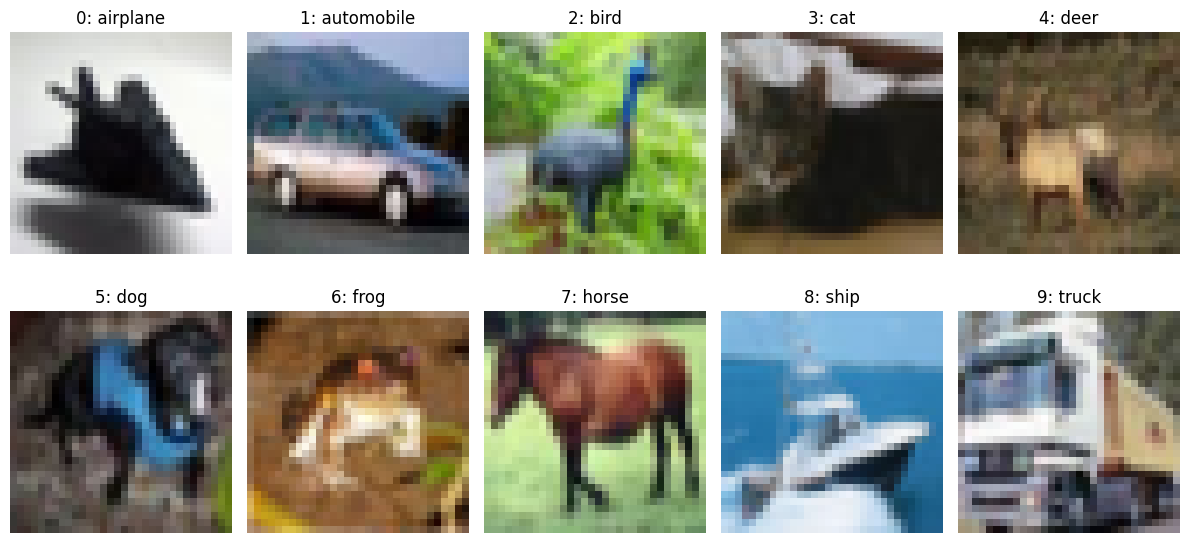

In [110]:
# Display CIFAR-10 categories and show one example image per class
# Try to use an existing CIFAR10 dataset if available, otherwise load a fresh one (ToTensor for consistent plotting)
cifar_ds = None
if isinstance(globals().get("train_dataset", None), datasets.CIFAR10):
    cifar_ds = train_dataset
else:
    cifar_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms.ToTensor())

classes = getattr(cifar_ds, "classes", None)
if classes is None:
    classes = datasets.CIFAR10(root="./data", train=True, download=True).classes

print("CIFAR-10 classes:")
for i, cls in enumerate(classes):
    print(f"{i}: {cls}")

# collect one example per class
examples = {}
for img, lbl in cifar_ds:
    if lbl not in examples:
        examples[lbl] = img
    if len(examples) == 10:
        break

# plot grid: 2 rows x 5 cols
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for idx in range(10):
    img = examples[idx]
    # handle tensor (C,H,W) or PIL image
    if isinstance(img, torch.Tensor):
        npimg = img.numpy()
        # if single-channel, stack to 3 channels for display
        if npimg.shape[0] == 1:
            npimg = np.repeat(npimg, 3, axis=0)
        npimg = np.transpose(npimg, (1, 2, 0))
        # if values are in [0,1] already, use as is
    else:
        npimg = np.array(img) / 255.0

    ax = axes.flat[idx]
    ax.imshow(npimg)
    ax.set_title(f"{idx}: {classes[idx]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Exercise-3: Regularization with Alpha Dropout and MC Dropout
Using the MNIST dataset, extend the previously trained deep neural network by applying
Alpha Dropout. Then, without retraining, use Monte Carlo (MC) Dropout at inference
to estimate if you can achieve better accuracy. Set random seeds to 42. Use the following
configuration:
* Flatten input images to 28 × 28 = 784 features
* 3 hidden layers, 64 neurons each
* SELU activation function (required for Alpha Dropout)
* LeCun normal initialization
* Alpha Dropout rate: 0.1 in all hidden layers
* Output layer: 10 neurons with softmax
* Optimizer: Nadam
* learning rate = 0.001, loss=sparse categorical crossentropy
* epochs = 50, batch size = 32
* Use only the first 1000 training samples and first 200 test samples
* For MC Dropout, enable dropout during inference and average predictions over 20 stochastic forward passes

In [111]:
# 1. Set random seed
set_seeds(SEED)
# 2. Load MNIST + validation split (10%)
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_subset = Subset(train_dataset, range(1000))   # first 1000 samples
test_subset  = Subset(test_dataset, range(200))     # first 200 samples

batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)


# 3. Define Model (SELU + AlphaDropout)
class MNISTAlphaDropoutNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 64),
            nn.SELU(),
            nn.AlphaDropout(p=0.1),
            nn.Linear(64, 64),
            nn.SELU(),
            nn.AlphaDropout(p=0.1),
            nn.Linear(64, 64),
            nn.SELU(),
            nn.AlphaDropout(p=0.1),
            nn.Linear(64, 10)  # logits
        )
        self.init_lecun_normal()

    def init_lecun_normal(self):
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                fan_in = layer.weight.shape[1]
                nn.init.normal_(layer.weight, mean=0.0, std=np.sqrt(1.0 / fan_in))
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.model(x)

model = MNISTAlphaDropoutNet()

# 4. Optimizer & loss
optimizer = optim.NAdam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 5. Train normally
patience = 5
best_loss = float('inf')
best_model_state = None
counter = 0

epochs = 50

for epoch in range(epochs):
    # ---- Training ----
    model.train()
    total_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)

    # ---- Validation ----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            preds = model(x_val)
            loss = criterion(preds, y_val)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # ---- Early Stopping Logic ----
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0  # Reset patience counter
    else:
        counter += 1
        if counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}.")
            break

# -------------------------
# 6. Standard accuracy (dropout OFF)
# -------------------------
def evaluate(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader:
            preds = model(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total


Epoch 01 | Train Loss: 2.0500 | Val Loss: 1.0564
Epoch 02 | Train Loss: 1.2509 | Val Loss: 0.7002
Epoch 03 | Train Loss: 0.8701 | Val Loss: 0.5464
Epoch 04 | Train Loss: 0.7051 | Val Loss: 0.4239
Epoch 05 | Train Loss: 0.5489 | Val Loss: 0.4120
Epoch 06 | Train Loss: 0.4796 | Val Loss: 0.3990
Epoch 07 | Train Loss: 0.4327 | Val Loss: 0.3489
Epoch 08 | Train Loss: 0.4036 | Val Loss: 0.3831
Epoch 09 | Train Loss: 0.3629 | Val Loss: 0.3718
Epoch 10 | Train Loss: 0.3363 | Val Loss: 0.3754
Epoch 11 | Train Loss: 0.2637 | Val Loss: 0.3137
Epoch 12 | Train Loss: 0.2853 | Val Loss: 0.3312
Epoch 13 | Train Loss: 0.2407 | Val Loss: 0.3186
Epoch 14 | Train Loss: 0.2218 | Val Loss: 0.3708
Epoch 15 | Train Loss: 0.1822 | Val Loss: 0.3798
Epoch 16 | Train Loss: 0.2058 | Val Loss: 0.3638

Early stopping triggered at epoch 16.


## Q3.1 Report the test accuracy of the network with Alpha Dropout applied during training

In [112]:
base_acc = evaluate(model)
print(f"Standard Test Accuracy (Dropout OFF): {base_acc:.4%}")

Standard Test Accuracy (Dropout OFF): 91.5000%


## Q3.2 Report the MC Dropout-enhanced accuracy (averaging 20 stochastic predictions).

In [113]:
def mc_dropout_predict(model, x, mc_runs=20):
    model.train()  # <— enable dropout at inference
    preds = []
    with torch.no_grad():
        for _ in range(mc_runs):
            logits = model(x)
            preds.append(torch.softmax(logits, dim=1))
    return torch.stack(preds).mean(0)  # average prediction


def evaluate_mc_dropout(model, mc_runs=20):
    correct = 0
    total = 0
    model.eval()  # we handle dropout manually inside function
    for x, y in val_loader:
        probs = mc_dropout_predict(model, x, mc_runs)
        pred = probs.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return correct / total

mc_acc = evaluate_mc_dropout(model)
print(f"MC Dropout Test Accuracy (Dropout ON, 20 passes): {mc_acc:.4%}")

MC Dropout Test Accuracy (Dropout ON, 20 passes): 89.5000%


## Explanation


# Exercise-4: Transfer Learning with Pre-trained CNN
Use a pre-trained convolutional neural network (CNN) as a feature extractor and fine-
tune a classifier on a subset of the CIFAR-10 dataset. Set random seeds to 42. Follow
the configuration below:
* Load CIFAR-10 and normalize pixel values to [0,1]
* Use only the first 2000 training samples and first 500 test samples
* Load MobileNetV2 from tensorflow.keras.applications, with include top=False and weights=’imagenet’
* Freeze all layers of the pre-trained base
* Add a classifier on top:
    * GlobalAveragePooling2D
    * Dense layer with 128 neurons, ReLU activation
    * Dropout: 0.2
    * Output layer: 10 neurons with softmax
* Optimizer: Adam, learning rate = 0.001
* Loss: sparse categorical crossentropy
* epochs = 5, batch size = 32

In [114]:
# Set random seed
set_seeds(SEED)

# CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),    # MobileNet requires 224x224
    transforms.ToTensor(),            # Scales to [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]), # ImageNet stats (Imperically found to work well)
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_subset = Subset(train_dataset, range(2000))
test_subset = Subset(test_dataset, range(500))

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

# Load MobileNetV2, remove top, freeze base
mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

for p in mobilenet.features.parameters():  # freeze backbone only
    p.requires_grad = False

# Replace classifier to mimic Keras: GAP → Dense128 → Dropout → Dense10
# (BUT PyTorch already does GAP before classifier)
mobilenet.classifier = nn.Sequential(
    nn.Linear(1280, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 10)  # Softmax removed (CrossEntropyLoss handles it)
)

device = "cuda" if torch.cuda.is_available() else "cpu"
mobilenet.to(device)

# Training setup
criterion = nn.CrossEntropyLoss()  # sparse categorical crossentropy
optimizer = optim.Adam(mobilenet.classifier.parameters(), lr=0.001)

# Train
for epoch in range(5):
    mobilenet.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/5, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/5, Loss: 1.7070
Epoch 2/5, Loss: 1.1025
Epoch 3/5, Loss: 0.9515
Epoch 4/5, Loss: 0.8595
Epoch 5/5, Loss: 0.7623


## Q4.1 Report the test accuracy of the model

In [115]:
mobilenet.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {(correct/total)*100:.2f}%")

Test Accuracy: 69.60%


## Explanation
This model performs much better than the previous DNN model did on the CIFAR-10 datset. This is because the pretrained MobileNetV2 is better suited to identify images compared to a pure DNN only trained on a small dataset (5000 training images). 

# Exercise-5: Deeper CNN Training on SVHN
Train a controlled deep convolutional neural network (CNN) on a subset of the SVHN
dataset. Set random seeds to 42. Load and preprocess SVHN. Build the network using
the following configuration:
* Load SVHN and normalize pixel values to [0,1]
* Use only the first 2000 training samples and first 500 test samples
* Input shape: 32 × 32 × 3
* CNN architecture:
  * Conv2D: 32 filters, 3×3 kernel, ReLU activation
  * Conv2D: 32 filters, 3×3 kernel, ReLU activation
  * MaxPooling2D: 2×2
  * Conv2D: 64 filters, 3×3 kernel, ReLU activation
  * Conv2D: 64 filters, 3×3 kernel, ReLU activation
  * MaxPooling2D: 2×2 Flatten
  * Dense: 256 neurons, ReLU activation
  * Dropout: 0.3
  * Output layer: 10 neurons with softmax
* Optimizer: Adam, learning rate = 0.001
* Loss: sparse categorical crossentropy
* epochs = 15, batch size = 32

In [116]:
# Set random seed
set_seeds(SEED)
# 1. Load SVHN (normalize to [0,1])

transform = transforms.ToTensor()  # already scales to [0,1]

train_data = datasets.SVHN(root="./data", split='train', download=True, transform=transform)
test_data  = datasets.SVHN(root="./data", split='test',  download=True, transform=transform)

# Use dataset subsets
train_subset = Subset(train_data, range(2000))
test_subset  = Subset(test_data, range(500))

batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# 2. Define CNN Model
class SVHNCNN(nn.Module):
    def __init__(self):
        super(SVHNCNN, self).__init__()

        # First block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # assuming RGB input
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        # Second block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Fully connected
        self.fc1 = nn.Linear(64 * 8 * 8, 256)  # works for 32×32 input images
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 10)  # output layer

        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        # Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # logits, no softmax here
        
        return x

model = SVHNCNN()

# 3. Optimizer & Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 4. Training loop
epochs = 15
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for x, y in train_loader:
        # SVHN labels are shape (N,1), squeeze needed
        y = y.long().squeeze()

        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1:02d} | Loss: {total_loss/len(train_loader):.4f}")

print("Training complete.")

Epoch 01 | Loss: 2.2417
Epoch 02 | Loss: 2.2297
Epoch 03 | Loss: 2.2310
Epoch 04 | Loss: 2.2277
Epoch 05 | Loss: 2.2291
Epoch 06 | Loss: 2.2334
Epoch 07 | Loss: 2.2277
Epoch 08 | Loss: 2.2318
Epoch 09 | Loss: 2.2284
Epoch 10 | Loss: 2.2256
Epoch 11 | Loss: 2.2235
Epoch 12 | Loss: 2.2335
Epoch 13 | Loss: 2.2314
Epoch 14 | Loss: 2.2276
Epoch 15 | Loss: 2.2275
Training complete.


## Q5.1 Report the test accuracy of the deeper CNN model.

In [117]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader:
        y = y.long().squeeze()
        preds = model(x).argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"Test Accuracy: {correct/total:.4%}")

Test Accuracy: 19.2000%


## Explanation
The SVHN dataset is a complicated dataset that requires a well trained model to be able to have a decent accuracy. When using only 2000 training images when training the CNN, it will not have the time to be able to pick up on the important features in the image and the accuracy will remain low.

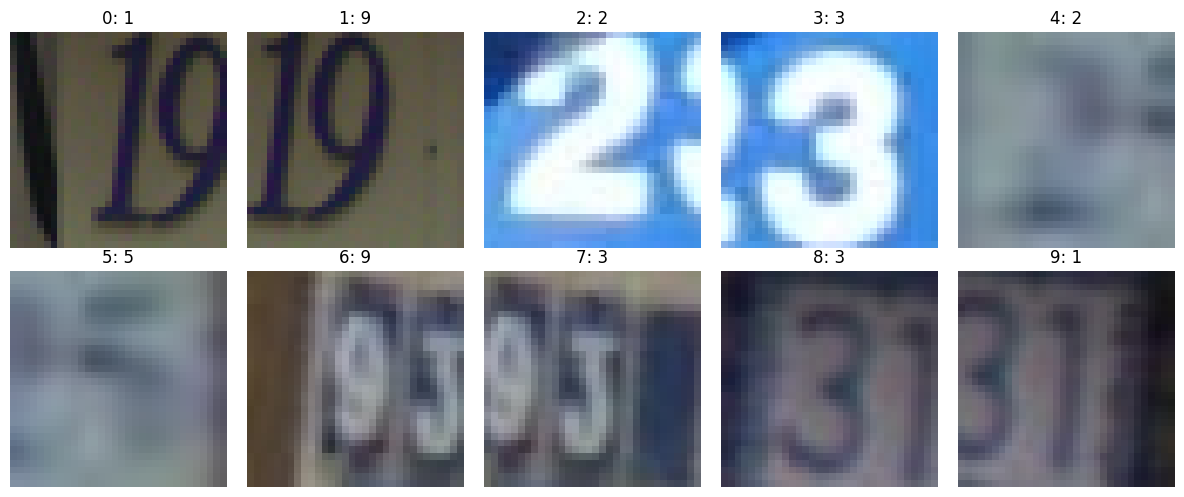

In [118]:
# Display first ten images from the SVHN training dataset
ds = globals().get("train_data", None)
if ds is None or not isinstance(ds, datasets.SVHN):
    ds = datasets.SVHN(root="./data", split='train', download=True, transform=transforms.ToTensor())

n = 10
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flatten()):
    img, lbl = ds[i]
    # img is a tensor C,H,W -> convert to H,W,C for matplotlib
    if isinstance(img, torch.Tensor):
        npimg = img.numpy().transpose(1, 2, 0)
    else:
        npimg = np.array(img) / 255.0
    ax.imshow(npimg)
    ax.set_title(f"{i}: {int(lbl)}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Exercise-6: CNN with SGD, MC Dropout, and Epistemic Uncertainty
Train a controlled convolutional neural network (CNN) on a subset of the SVHN dataset
using SGD optimizer. Then, apply Monte Carlo (MC) Dropout at inference to estimate
both test accuracy and epistemic uncertainty. Set random seeds to 42. Use the following
configuration:
* Load SVHN and normalize pixel values to [0,1]
* Use only the first 2000 training samples and first 500 test samples
* Input shape: 32 × 32 × 3
* CNN architecture:
  * Conv2D: 32 filters, 3×3 kernel, ReLU activation
  * MaxPooling2D: 2×2
  * Conv2D: 64 filters, 3×3 kernel, ReLU activation
  * MaxPooling2D: 2×2
  * Flatten
  * Dense: 128 neurons, ReLU activation
  * Dropout: 0.25 (keep during inference for MC Dropout)
  * Output layer: 10 neurons with softmax
* Optimizer: SGD with momentum = 0.9, learning rate = 0.01
* Loss: sparse categorical crossentropy
* epochs = 15, batch size = 32
* For MC Dropout:
  * Enable dropout during inference
  * Average predictions over 20 stochastic forward passes
  * Compute the epistemic uncertainty as the predictive variance across passes

In [119]:
# Set random seed
set_seeds(SEED)

# 1. Load SVHN (normalize to [0,1])
transform = transforms.ToTensor()

train_data = datasets.SVHN(root="./data", split='train', download=True, transform=transform)
test_data  = datasets.SVHN(root="./data", split='test',  download=True, transform=transform)

train_subset = Subset(train_data, range(2000))
test_subset  = Subset(test_data, range(500))

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_subset, batch_size=32, shuffle=False)

# 2. CNN Model
class MC_Dropout_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(64*8*8, 128), nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 10)  # logits
        )

    def forward(self, x):
        return self.net(x)

model = MC_Dropout_CNN()

# 3. Optimizer & Loss
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# 4. Training
epochs = 15
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for x, y in train_loader:
        y = y.long().squeeze()
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1:02d} | Loss: {total_loss/len(train_loader):.4f}")

print("Training complete.\n")

Epoch 01 | Loss: 2.2439
Epoch 02 | Loss: 2.2325
Epoch 03 | Loss: 2.2279
Epoch 04 | Loss: 2.2259
Epoch 05 | Loss: 2.2226
Epoch 06 | Loss: 2.2200
Epoch 07 | Loss: 2.2182
Epoch 08 | Loss: 2.2147
Epoch 09 | Loss: 2.2068
Epoch 10 | Loss: 2.1950
Epoch 11 | Loss: 2.1814
Epoch 12 | Loss: 2.1639
Epoch 13 | Loss: 2.1246
Epoch 14 | Loss: 2.0657
Epoch 15 | Loss: 1.9756
Training complete.



## Q6.1 Report the plain test accuracy of the CNN trained with SGD (no MC Dropout).

In [120]:
def eval_standard(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            y = y.long().squeeze()
            preds = model(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

base_acc = eval_standard(model)
print(f"Standard Test Accuracy: {base_acc:.4%}")

Standard Test Accuracy: 28.6000%


## Q6.2 Report the MC Dropout-enhanced accuracy (averaging 20 stochastic predictions).

In [121]:
def mc_dropout_predict(model, x, mc_runs=20):
    model.train()  # enable dropout for MC inference
    preds = []
    with torch.no_grad():
        for _ in range(mc_runs):
            logits = model(x)
            preds.append(torch.softmax(logits, dim=1))
    return torch.stack(preds)  # shape: [mc_runs, batch, 10]

def eval_mc_dropout(model, mc_runs=20):
    correct, total = 0, 0
    uncertainties = []

    for x, y in test_loader:
        y = y.long().squeeze()

        mc_preds = mc_dropout_predict(model, x, mc_runs)
        mean_probs = mc_preds.mean(dim=0)  # mean prediction
        var_probs = mc_preds.var(dim=0).mean(dim=1)  # avg var per sample (epistemic)

        preds = mean_probs.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

        uncertainties.extend(var_probs.cpu().numpy())

    return (correct / total), np.array(uncertainties)

mc_acc, epistemic_unc = eval_mc_dropout(model, mc_runs=20)

print(f"MC Dropout Test Accuracy: {mc_acc:.4%}")

MC Dropout Test Accuracy: 28.8000%


## Q6.3 Compute the average epistemic uncertainty (mean predictive variance) across all test samples. Report it as a deterministic number rounded to 3 decimal places

In [122]:
print(f"Mean Epistemic Uncertainty: {epistemic_unc.mean():.6f}")
print(f"Uncertainty Std: {epistemic_unc.std():.6f}")

Mean Epistemic Uncertainty: 0.000426
Uncertainty Std: 0.000352


## Explanation
When using SGD and MC-dropout the accuracy of the model will increase but will still be low because of the few training images. 